<h1 align='center'>  Bosque Aleatorio </h1> 

Un modelo Random Forest está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping). Esto implica que cada árbol se entrena con unos datos ligeramente distintos. En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Para entender cómo funcionan los modelos Random Forest es necesario conocer primero los conceptos de ensemble y bagging.

## Ejemplo de un Bosque Aleatorio

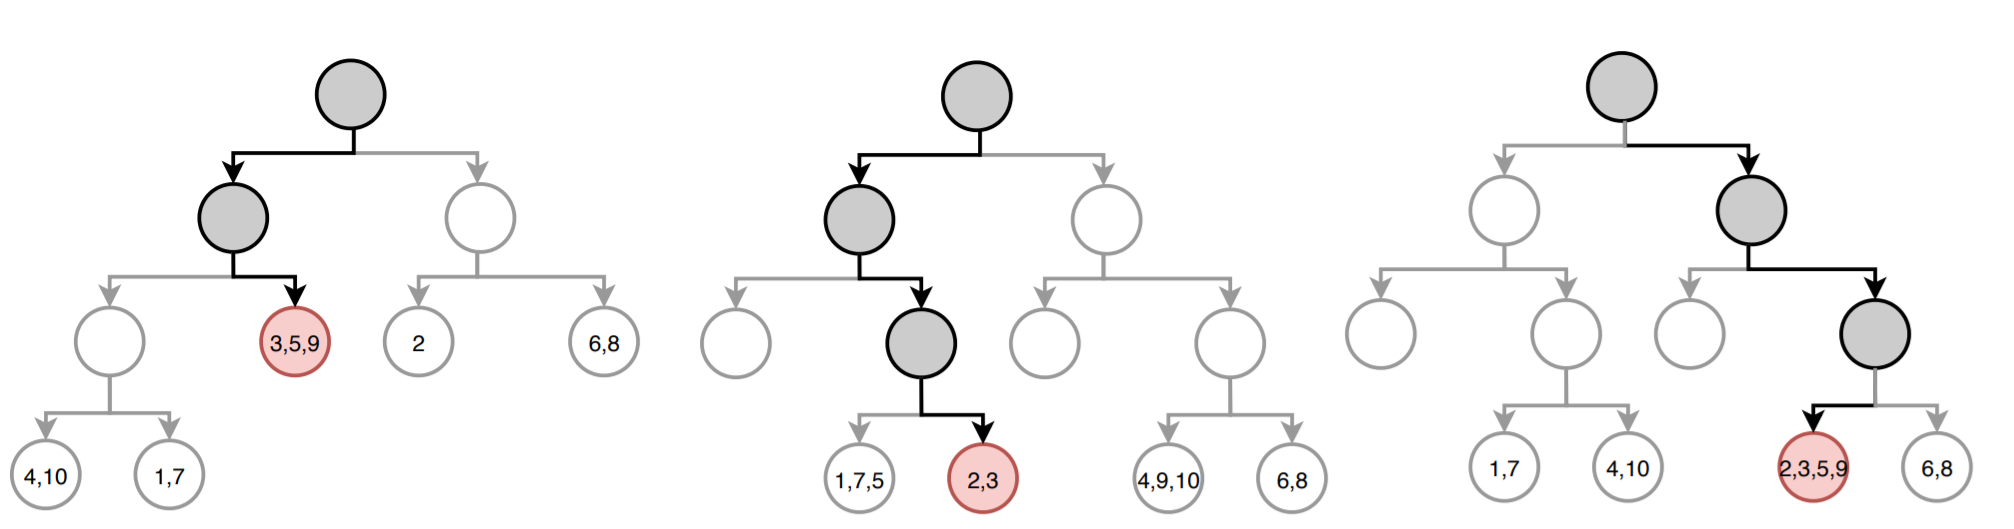

<h2> Mapa </h2>
<ul>
    <li>1-. Formular la pregunta y determinar el modelo</li>
    <li>2-. Adquisición de datos</li>
    <li>3-. Identificación y corrección de los puntos de datos faltantes/anomalías según sea necesario</li>
    <li>4-. Preprocesar los datos</li>
    <li>5-. Entrenar el modelo en los datos de entrenamiento</li>
    <li>6-. Predicciones sobre los datos de prueba y metricas de rendimiento</li>
    <li>7-. Comparar las predicciones con los objetivos conocidos del conjunto de pruebas y calcule las métricas de rendimiento</li>
    <li>8-. Importancia de los predictores</li>
</ul>

# 2-. Adquisición de datos
Primero, necesitamos algunos datos. Para usar un ejemplo realista, recuperé datos de pacientes del Hospital Herminda Martin de Chillan. En general, aproximadamente el 80 % del tiempo dedicado al análisis de datos es limpiar y recuperar datos, pero esta carga de trabajo se puede reducir encontrando fuentes de datos de alta calidad.

In [248]:
# Libreria para la manipulación de los datos
import pandas as pd
import numpy as np

# Leer el dataframe
dataframe = pd.read_excel('../bdd/bdd_final.xlsx')
dataframe.head(5)

,CLAVE,COMUNA,TELEFONOS,FICHA CLINICA,CTA CTE,EDAD,PESO,TALLA,HTA,DIABETES,OTRAS PATOLOGIAS,FUMA,FC,PAS,PAD,GLUCOSA,Hb A/C %,COL. TOTAL,TRIGLICERIDOS,LDL,HDL,HCTO,HB,VCM,HCM,VHS,PLAQUETAS,INR,CONTEO G.B.,P.C.R,Nitrogeno Ureico,Uremia,Creatinina,TTPA,TP,NA,K,...,NIHSS INICO ACV,RANKIN INICIO ACV,NIHSS alta ACV,RANKIN alta ACV,NIHSS 6M,RANKIN 6M,diag Elopez,DIAG. NEUROLOGICO,Diag2,Diag3,FECHA TOMA MUESTRA,Estado paciente,Fecha defuncion,CAUSA DEFUNCION,MOTIVO DE DESCARTE,TROMBOLISIS,eduardo,sirve,escala,exosomes 1,exosomes 2,VEGF ab1,VEGF ab2,VEGF prome,plgf mg prot,plgf mg prot.1,plgf promedio,logVEGF,logPlGF,logPCR,PCR/VEGF ratio,PCR/PLGF ratio,IL-6 (pg/ml),IL-6 corregida,log IL-6,IL-6/VEGF,IL-6/PlGF
0,1,san carlos,NaN,2.012418e+09,11998898.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,64.0,137.09,5.9,268.0,130.0,202.0,40.0,42.0,14.4,90.8,30.8,31.0,267.0,1.08,41.9,1.48,21.13,45.22,0.93,21.8,11.0,137.83,4.33,...,14.0,5.0,42.0,6.0,fallecido,6,mayor,INFARTO CEREBRAL DEBIDO A TROMBOSIS DE ARTERAI...,NaN,NaN,2015-11-05 00:00:00,Fallecido,2015-05-11,PCR,NaN,NaN,"infarto mayor acm malign, fallece por herniacion",si,taci,NaN,NaN,54.631620,62.640451,58.636035,10.096588,8.739520,9.418054,1.768165,0.973961,0.170262,0.096293,0.174814,18.586835,0.156953,-0.804231,-0.454840,-0.825732
1,2,coihueco,41723921-74822219,2.000150e+09,12002852.0,54.0,88.0,165.0,si,si,vertigo postural paroxistico,no,56.0,130.0,89.0,NaN,6.5,187.0,130.0,118.0,44.0,39.0,13.9,87.3,30.4,8.0,159.0,NaN,8.3,1.67,NaN,NaN,0.90,NaN,NaN,NaN,NaN,...,6.0,5.0,0.0,2.0,0,2,menor,ACV Isquemico transitorio TIA,hipertension arterial primaria,vertigo paroxistico benigno,2015-12-05 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.186725,159.899660,139.043193,59.910126,52.490085,56.200106,2.143150,1.749737,0.222716,0.103920,0.127286,1.263441,0.012818,-1.892186,-0.882899,-1.081411
2,3,chillan,71818219-50323843,9.808599e+07,12003092.0,78.0,NaN,NaN,si,si,INSULINO REQUERIENTE,NaN,91.0,152.0,75.0,359.42,13.8,159.0,97.0,26.0,35.0,41.0,14.3,83.3,28.4,13.0,161.0,0.89,8.5,12.11,12.68,27.14,0.74,26.3,9.8,137.00,3.84,...,5.0,3.0,2.0,1.0,NaN,NaN,menor,Infarto lagunar capsular derecho,hipertension esencial primaria,diabetes mellitus no especificada,2015-12-05 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3.250000e+10,3.425000e+10,38.456172,34.306221,36.381196,15.081331,17.607652,16.344491,1.560877,1.213371,1.083144,0.693933,0.892673,49.091862,0.436365,-0.360150,-0.230736,-0.296817
3,4,coihueco,77107584-93406930,9.772094e+06,11995391.0,87.0,52.5,NaN,si,si,"dislipidemia,secuela de infarto",NaN,59.0,136.0,86.0,186.20,5.9,193.0,133.0,115.0,51.0,34.5,11.7,87.9,29.8,27.0,242.0,0.90,7.0,1.15,24.10,51.60,0.92,27.2,10.1,137.10,4.03,...,1.0,4.0,0.0,2.0,0,2,menor,ACV lacunar derecho,TIA carotideo,IAM antiguo,2015-05-13 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.906663,170.742565,179.824614,53.025957,38.450115,45.738036,2.254849,1.660278,0.060698,0.026919,0.036559,96.544126,0.934859,-0.029254,-0.012974,-0.017620
4,5,yungay,99240760-77884029,9.809511e+07,12014450.0,69.0,94.0,NaN,si,si,NaN,no,104.0,154.0,95.0,170.00,16.7,184.0,137.0,125.0,32.0,46.7,16.7,90.4,32.4,16.0,259.0,1.28,12.1,1.28,16.69,35.72,1.05,24.2,13.0,137.70,4.16,...,3.0,4.0,2.0,1.0,0,1,mayor,Infarto cerebral debido a embolia de arterias ...,hipertension primaria,diabetes mellitus no especificada,NaN,Vivo,NaT,NaN,NaN,NaN,infarto moderado fosa posterior troncocerebeloso,si,poci,2.480000e+08,2.675000e+10,108.910218,98.272459,103.591338,62.935936,47.237011,55.086473,2.015323,1.741045,0.107210,0.053197,0.061578,43.309864,0.379102,-0.421244,-0.209021,-0.241949


In [249]:
print('Existen {} pacientes con {} variables.'.format(*dataframe.shape))

Existen 75 pacientes con 85 variables.


# 3-. Identificación y corrección de los puntos de datos faltantes/anomalías según sea necesario

En este item, la base de datos será rellenada.

## Eliminación las filas de los pacientes que se expulsaron de la BDD

In [250]:
dataframe.drop(dataframe[(dataframe['diag Elopez'] == 'out')].index, inplace=True)
dataframe.head(7)

,CLAVE,COMUNA,TELEFONOS,FICHA CLINICA,CTA CTE,EDAD,PESO,TALLA,HTA,DIABETES,OTRAS PATOLOGIAS,FUMA,FC,PAS,PAD,GLUCOSA,Hb A/C %,COL. TOTAL,TRIGLICERIDOS,LDL,HDL,HCTO,HB,VCM,HCM,VHS,PLAQUETAS,INR,CONTEO G.B.,P.C.R,Nitrogeno Ureico,Uremia,Creatinina,TTPA,TP,NA,K,...,NIHSS INICO ACV,RANKIN INICIO ACV,NIHSS alta ACV,RANKIN alta ACV,NIHSS 6M,RANKIN 6M,diag Elopez,DIAG. NEUROLOGICO,Diag2,Diag3,FECHA TOMA MUESTRA,Estado paciente,Fecha defuncion,CAUSA DEFUNCION,MOTIVO DE DESCARTE,TROMBOLISIS,eduardo,sirve,escala,exosomes 1,exosomes 2,VEGF ab1,VEGF ab2,VEGF prome,plgf mg prot,plgf mg prot.1,plgf promedio,logVEGF,logPlGF,logPCR,PCR/VEGF ratio,PCR/PLGF ratio,IL-6 (pg/ml),IL-6 corregida,log IL-6,IL-6/VEGF,IL-6/PlGF
0,1,san carlos,NaN,2.012418e+09,11998898.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,64.0,137.09,5.9,268.0,130.0,202.0,40.0,42.0,14.4,90.8,30.8,31.0,267.0,1.08,41.90,1.48,21.13,45.22,0.93,21.8,11.0,137.83,4.33,...,14.0,5.0,42.0,6.0,fallecido,6,mayor,INFARTO CEREBRAL DEBIDO A TROMBOSIS DE ARTERAI...,NaN,NaN,2015-11-05 00:00:00,Fallecido,2015-05-11,PCR,NaN,NaN,"infarto mayor acm malign, fallece por herniacion",si,taci,NaN,NaN,54.631620,62.640451,58.636035,10.096588,8.739520,9.418054,1.768165,0.973961,0.170262,0.096293,0.174814,18.586835,0.156953,-0.804231,-0.454840,-0.825732
1,2,coihueco,41723921-74822219,2.000150e+09,12002852.0,54.0,88.0,165.0,si,si,vertigo postural paroxistico,no,56.0,130.0,89.0,NaN,6.5,187.0,130.0,118.0,44.0,39.0,13.9,87.3,30.4,8.0,159.0,NaN,8.30,1.67,NaN,NaN,0.90,NaN,NaN,NaN,NaN,...,6.0,5.0,0.0,2.0,0,2,menor,ACV Isquemico transitorio TIA,hipertension arterial primaria,vertigo paroxistico benigno,2015-12-05 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.186725,159.899660,139.043193,59.910126,52.490085,56.200106,2.143150,1.749737,0.222716,0.103920,0.127286,1.263441,0.012818,-1.892186,-0.882899,-1.081411
2,3,chillan,71818219-50323843,9.808599e+07,12003092.0,78.0,NaN,NaN,si,si,INSULINO REQUERIENTE,NaN,91.0,152.0,75.0,359.42,13.8,159.0,97.0,26.0,35.0,41.0,14.3,83.3,28.4,13.0,161.0,0.89,8.50,12.11,12.68,27.14,0.74,26.3,9.8,137.00,3.84,...,5.0,3.0,2.0,1.0,NaN,NaN,menor,Infarto lagunar capsular derecho,hipertension esencial primaria,diabetes mellitus no especificada,2015-12-05 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3.250000e+10,3.425000e+10,38.456172,34.306221,36.381196,15.081331,17.607652,16.344491,1.560877,1.213371,1.083144,0.693933,0.892673,49.091862,0.436365,-0.360150,-0.230736,-0.296817
3,4,coihueco,77107584-93406930,9.772094e+06,11995391.0,87.0,52.5,NaN,si,si,"dislipidemia,secuela de infarto",NaN,59.0,136.0,86.0,186.20,5.9,193.0,133.0,115.0,51.0,34.5,11.7,87.9,29.8,27.0,242.0,0.90,7.00,1.15,24.10,51.60,0.92,27.2,10.1,137.10,4.03,...,1.0,4.0,0.0,2.0,0,2,menor,ACV lacunar derecho,TIA carotideo,IAM antiguo,2015-05-13 00:00:00,Vivo,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.906663,170.742565,179.824614,53.025957,38.450115,45.738036,2.254849,1.660278,0.060698,0.026919,0.036559,96.544126,0.934859,-0.029254,-0.012974,-0.017620
4,5,yungay,99240760-77884029,9.809511e+07,12014450.0,69.0,94.0,NaN,si,si,NaN,no,104.0,154.0,95.0,170.00,16.7,184.0,137.0,125.0,32.0,46.7,16.7,90.4,32.4,16.0,259.0,1.28,12.10,1.28,16.69,35.72,1.05,24.2,13.0,137.70,4.16,...,3.0,4.0,2.0,1.0,0,1,mayor,Infarto cerebral debido a embolia de arterias ...,hipertension primaria,diabetes mellitus no especificada,NaN,Vivo,NaT,NaN,NaN,NaN,infarto moderado fosa posterior troncocerebeloso,si,poci,2.480000e+08,2.675000e+10,108.910218,98.272459,103.591338,62.935936,47.237011,55.086473,2.015323,1.741045,0.107210,0.053197,0.061578,43.309864,0.379102,-0.421244,-0.209021,-0.241949
5,6,chillan,2225404-81923149,2.000139e+09,12015366.0,90.0,69.0,NaN,si,si,"insufisiencia renal,dislipidemia",no,55.0,216.0,84.0,160.95,12.3,166.0,128.0,102.0,37.0,37.0,12.0,96.3,31.9,45.0,169.0,1.00,9.40,20.99,39.33,84.17,1.73,25.7,10.2,137.92,4.78,...,5.0,NaN,1.0,5.0,1,2,mayor,Infarto cerebral debido a embolia de arterias ...,hipertension primaria,diabetes mellitus no especificada,20/05/1

In [251]:
print('Existen {} pacientes con {} variables.'.format(*dataframe.shape))

Existen 46 pacientes con 85 variables.


## Variables signaificativas para la investigación

### SOBRE EL DATASET

>**HTA**: ```"si" o "no"```

>**DIABETES**: ```"si" o "no"```

>**EDAD**: ```Edad del paciente```

>**GLUCOSA**: ```Nivel de azucar en la sangre```

>**COL. TOTAL**: ```Cantidad de Colesterol en la sangre```

>**TRIGLICERIDOS**: ```Cantidad de trigliceridos en la sangre```

>**INR**: ```Índice internacional normalizado (INR, por sus siglas en inglés) es un tipo de cálculo que se basa en los resultados de las pruebas de tiempo de protrombina```

>**CONTEO G.B.**: ```Conteo de globulos blancos en la sangre```

>**GLASGOW AL INICO ACV**: ```Escala de 15 puntos medica que es para medir el estado de conciencia. Esta pertence a la Inicial```

>**NIHSS INICO ACV**: ```Escala de 42 puntos más empleada para la valoración de funciones neurológicas básicas en la fase aguda del ictus isquémico, tanto al inicio como durante su evolución. Esta pertence a la Inicial```

>**NIHSS alta ACV**: ```Pertenece cuando es dado de alta el paciente```

In [252]:
# Tomaremos las variables más significativas para la investigación
columnasMuestra = ['HTA', 'DIABETES', 'EDAD', 'GLUCOSA', 'COL. TOTAL', 'TRIGLICERIDOS', 'INR', 'CONTEO G.B.', 'GLASGOW AL INICO ACV', 'NIHSS INICO ACV', 'NIHSS alta ACV']
dataset = dataframe[[*columnasMuestra]]

### Descripción general de los datos


In [253]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Información".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Forma de datos".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "Los primeros 5 datos".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "Los últimos 5 datos".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Data".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describir los datos".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(dataset)

--------------------    Información     --------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 74
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HTA                   42 non-null     object 
 1   DIABETES              34 non-null     object 
 2   EDAD                  44 non-null     float64
 3   GLUCOSA               38 non-null     float64
 4   COL. TOTAL            40 non-null     float64
 5   TRIGLICERIDOS         40 non-null     float64
 6   INR                   37 non-null     float64
 7   CONTEO G.B.           46 non-null     float64
 8   GLASGOW AL INICO ACV  29 non-null     float64
 9   NIHSS INICO ACV       39 non-null     float64
 10  NIHSS alta ACV        32 non-null     float64
dtypes: float64(9), object(2)
memory usage: 4.3+ KB
None
--------------------   Forma de datos   --------------------
(46, 11)

--------------------Los primeros 5 datos-----

### Missing data

In [254]:
valores_por_defecto = {
                         'HTA': "DESCONOCIDO",
                       'DIABETES' : "DESCONOCIDO",
                       'EDAD':dataset["EDAD"].median().round(),
                       'GLUCOSA':dataset["GLUCOSA"].median(),
                       'COL. TOTAL':dataset["COL. TOTAL"].median(), 
                       'TRIGLICERIDOS':dataset["TRIGLICERIDOS"].median(),
                       'INR':dataset["INR"].median(),
                       'CONTEO G.B.':dataset["CONTEO G.B."].median(),
                       'GLASGOW AL INICO ACV':dataset["GLASGOW AL INICO ACV"].median().round(),
                       'NIHSS INICO ACV':dataset["NIHSS INICO ACV"].median().round(), 
                       'NIHSS alta ACV':dataset["NIHSS alta ACV"].median().round(), 
                      }
# Missing Data
dataset = dataset.fillna(value=valores_por_defecto)
dataset.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV
0,DESCONOCIDO,DESCONOCIDO,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0
1,si,si,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0
2,si,si,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0
3,si,si,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0
4,si,si,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0


In [255]:
print('Existen {} pacientes con {} variables.'.format(*dataset.shape))

Existen 46 pacientes con 11 variables.


In [256]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(dataset)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 74
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HTA                   46 non-null     object 
 1   DIABETES              46 non-null     object 
 2   EDAD                  46 non-null     float64
 3   GLUCOSA               46 non-null     float64
 4   COL. TOTAL            46 non-null     float64
 5   TRIGLICERIDOS         46 non-null     float64
 6   INR                   46 non-null     float64
 7   CONTEO G.B.           46 non-null     float64
 8   GLASGOW AL INICO ACV  46 non-null     float64
 9   NIHSS INICO ACV       46 non-null     float64
 10  NIHSS alta ACV        46 non-null     float64
dtypes: float64(9), object(2)
memory usage: 4.3+ KB
None
--------------------     Data Shape     --------------------
(46, 11)

--------------------  The First 5 Data  -----

## Visualización de las variables

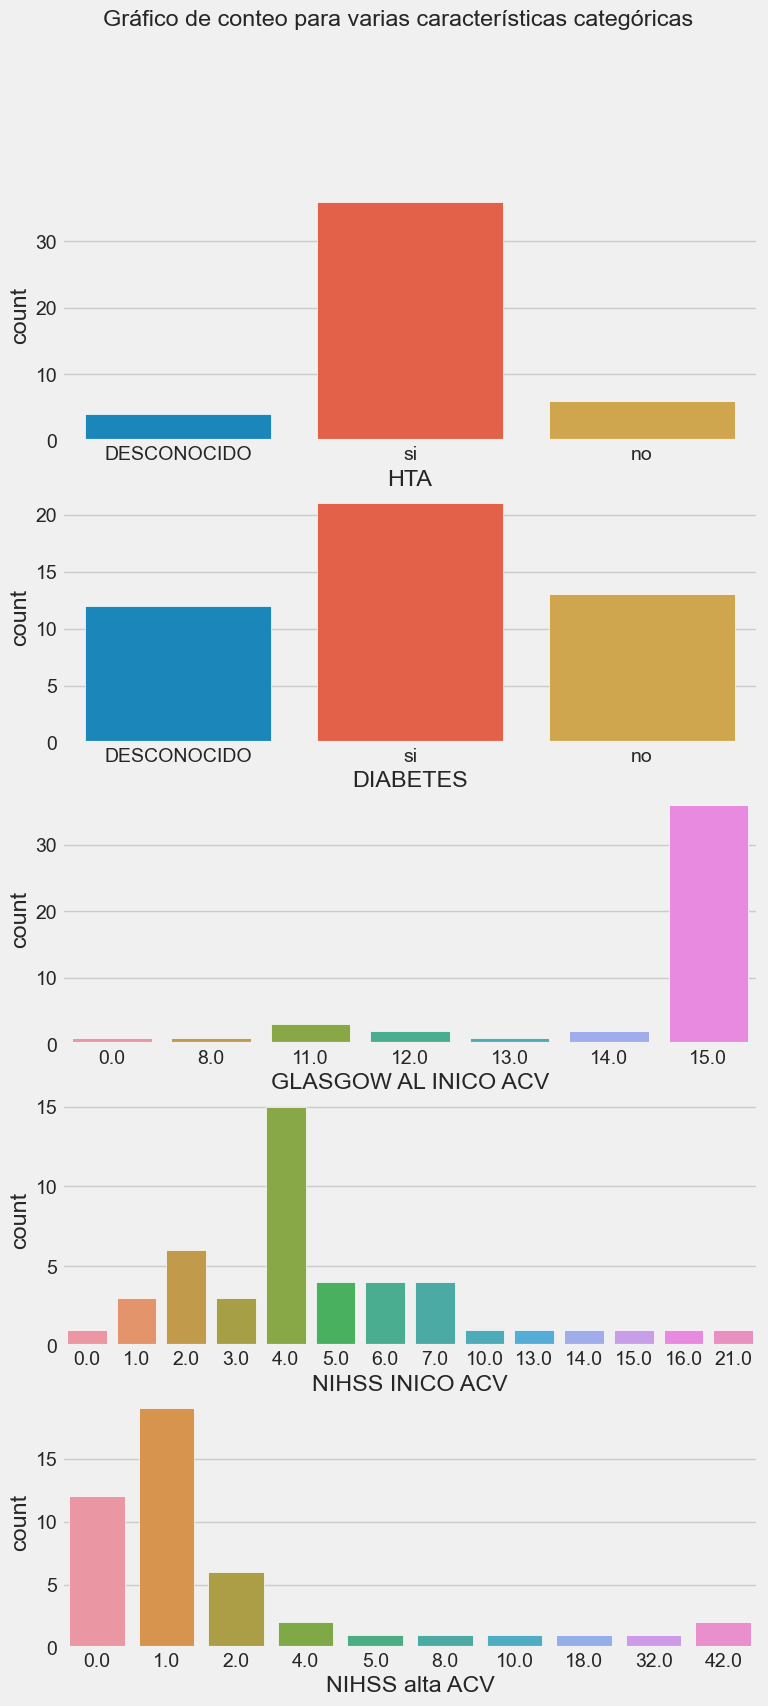

In [257]:
# Para gráficos matpltlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style


fig,axes = plt.subplots(5, figsize = (8, 18))
sns.set_style('darkgrid')
fig.suptitle("Gráfico de conteo para varias características categóricas")

sns.countplot(ax=axes[0],data=dataset,x='HTA')
sns.countplot(ax=axes[1],data=dataset,x='DIABETES')
sns.countplot(ax=axes[2],data=dataset,x='GLASGOW AL INICO ACV')
sns.countplot(ax=axes[3],data=dataset,x='NIHSS INICO ACV')
sns.countplot(ax=axes[4],data=dataset,x='NIHSS alta ACV')

plt.show()

C:\Users\Abraham\AppData\Local\Temp\ipykernel_9948\1091370767.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['EDAD'], bins=30, color='darkred', ax=axes[0, 0])
C:\Users\Abraham\AppData\Local\Temp\ipykernel_9948\1091370767.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['G

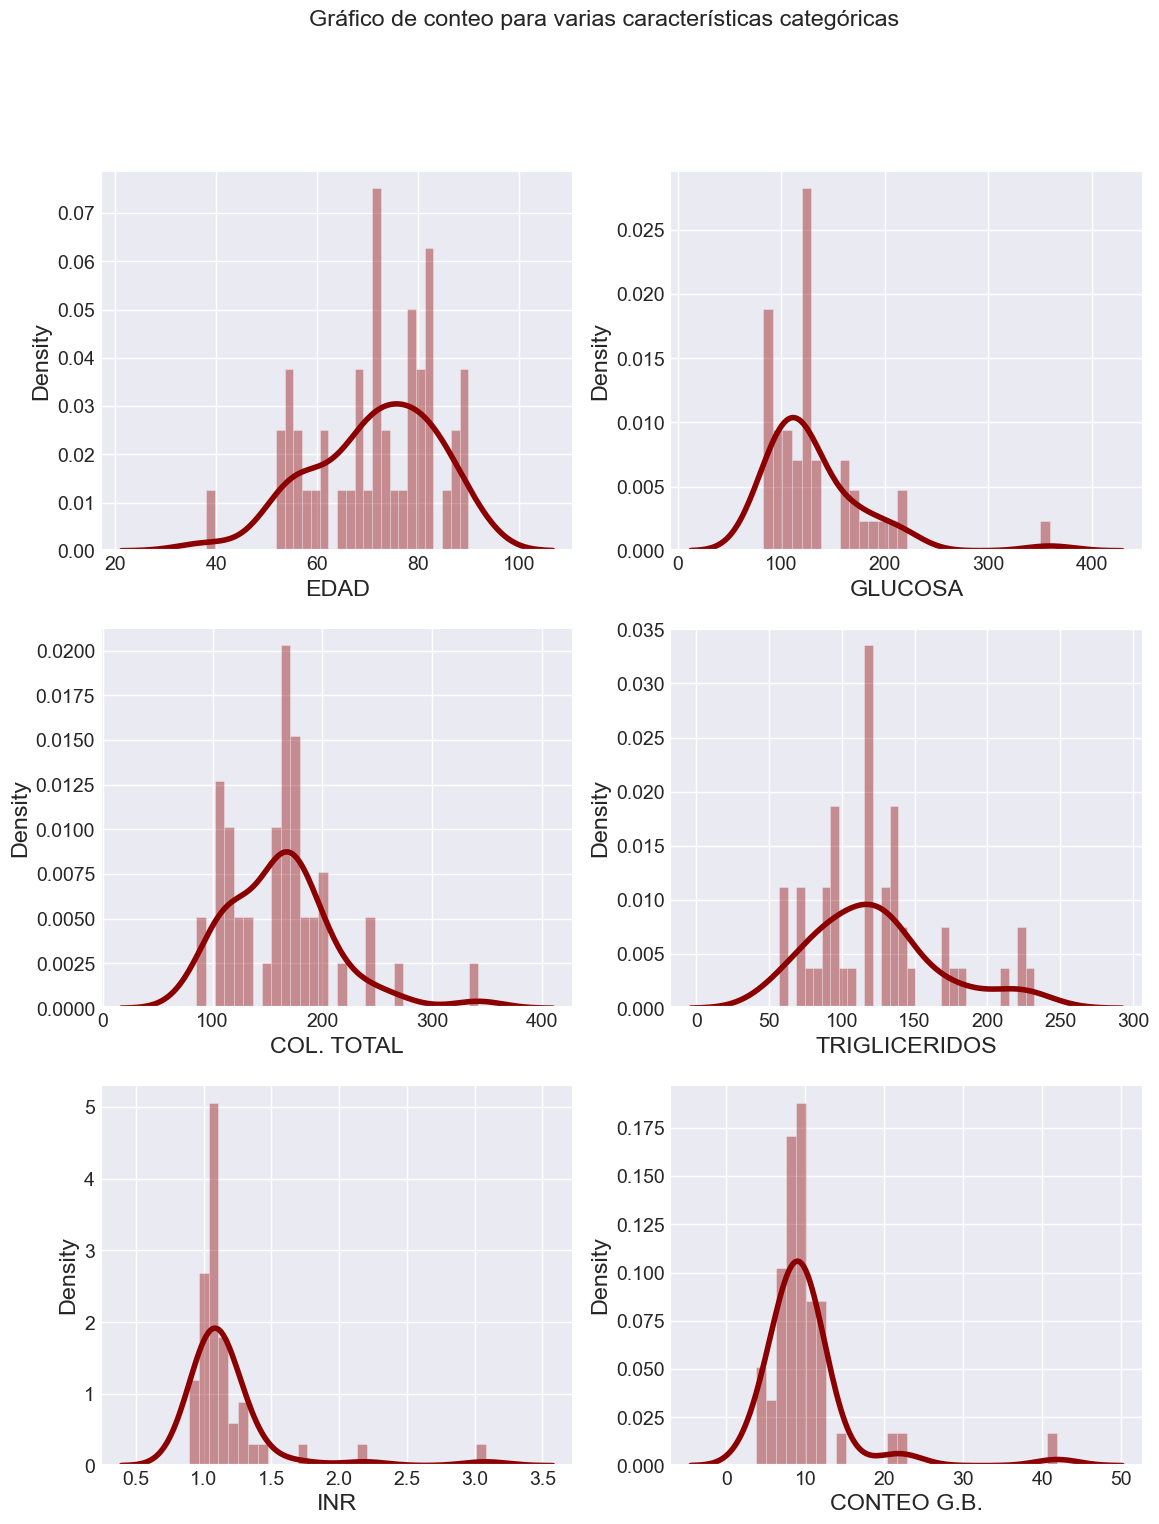

In [258]:
fig,axes = plt.subplots(3, 2, figsize = (12, 16))
sns.set_style('darkgrid')
fig.suptitle("Gráfico de conteo para varias características categóricas")

# Variables muy dispersas
sns.distplot(dataset['EDAD'], bins=30, color='darkred', ax=axes[0, 0])
sns.distplot(dataset['GLUCOSA'], bins=30, color='darkred', ax=axes[0, 1])
sns.distplot(dataset['COL. TOTAL'], bins=30, color='darkred', ax=axes[1, 0])
sns.distplot(dataset['TRIGLICERIDOS'], bins=30, color='darkred', ax=axes[1, 1])
sns.distplot(dataset['INR'], bins=30, color='darkred', ax=axes[2, 0])
sns.distplot(dataset['CONTEO G.B.'], bins=30, color='darkred', ax=axes[2, 1])

plt.show()

### Distibución de Diabetes e Hipertensión

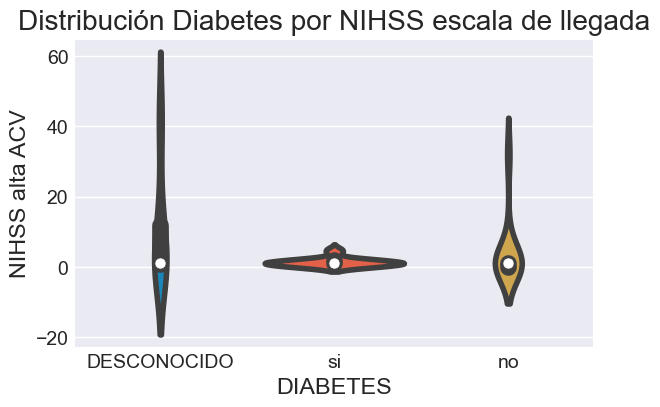

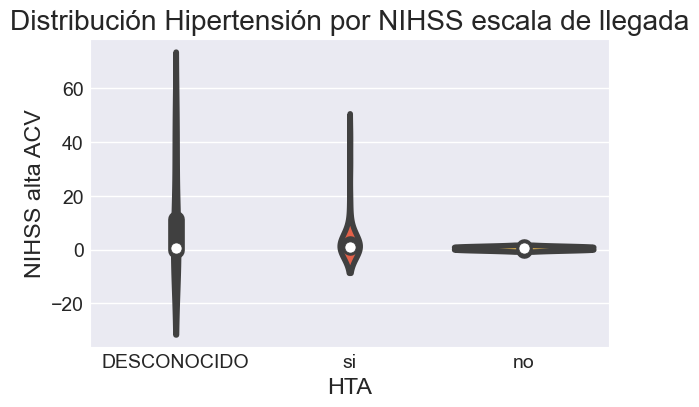

In [259]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'DIABETES',
        y     = 'NIHSS alta ACV',
        data  = dataset,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución Diabetes por NIHSS escala de llegada');

fig, ax2 = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'HTA',
        y     = 'NIHSS alta ACV',
        data  = dataset,
        #color = "white",
        ax    = ax2
    )

ax2.set_title('Distribución Hipertensión por NIHSS escala de llegada');

### Mapa de calor de variables numéricas

C:\Users\Abraham\AppData\Local\Temp\ipykernel_9948\2221177336.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()


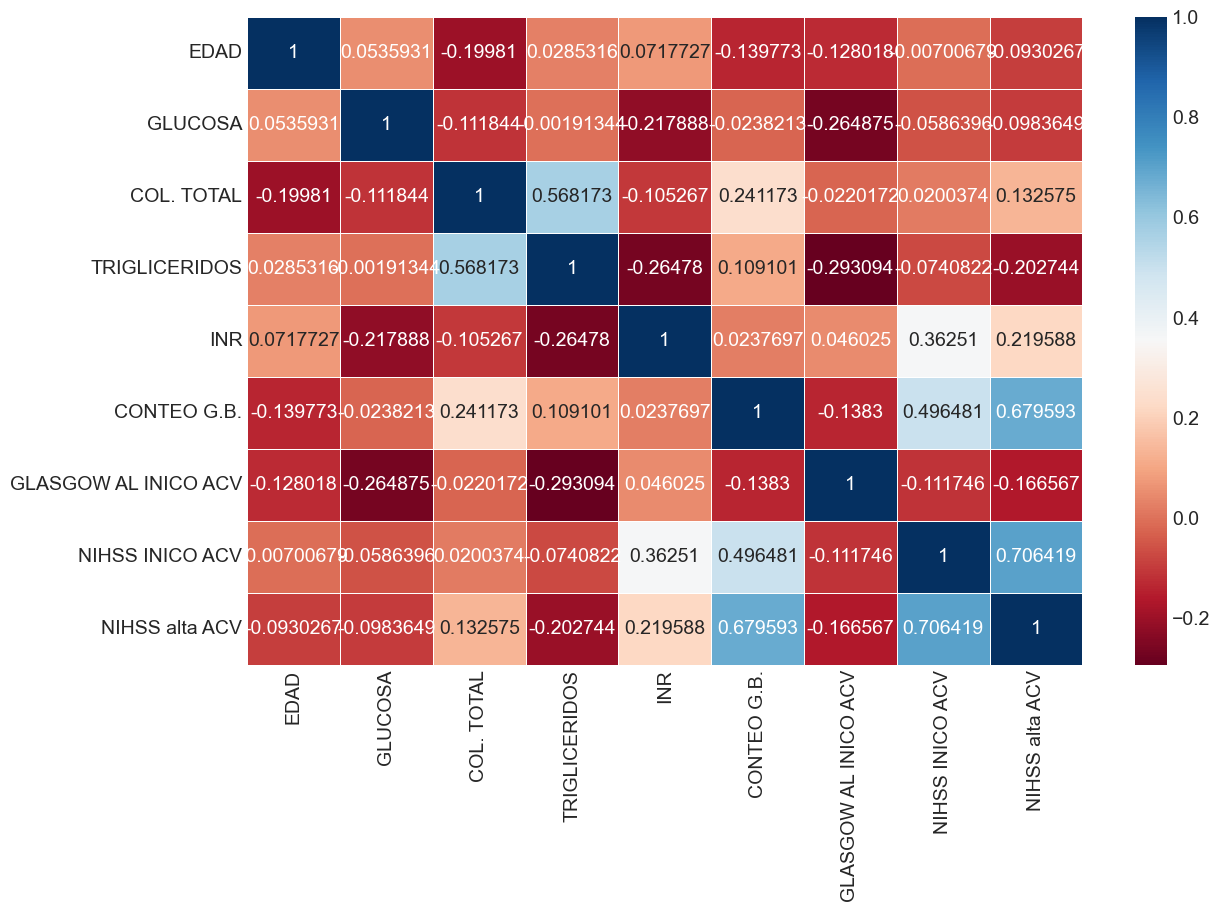

In [260]:
fig = plt.figure(figsize=(12,8))
corr = dataset.corr()
ax = sns.heatmap(corr, linewidths=.5, cmap="RdBu", annot=True, fmt="g")

# 4-. Preprocesar los datos
Preparar los datos para el modelo de aprendizaje automático

## Preparación de datos

Los pasos exactos para la preparación de los datos dependerán del modelo utilizado y de los datos recopilados, pero se requerirá cierta cantidad de manipulación de datos para cualquier aplicación de aprendizaje automático.

## Análisis de datos y clasifiación

Aqui se análizaran los datos a trabajar.

### Análisis de variable Objetivo
Variable más importante que nos interesa tener predicción.
 
#### Número de clase

In [261]:
dataset["NIHSS alta ACV"].value_counts()

1.0     19
0.0     12
2.0      6
42.0     2
4.0      2
8.0      1
10.0     1
18.0     1
32.0     1
5.0      1
Name: NIHSS alta ACV, dtype: int64

### Crear columna para NIHSS_INICO_CLASIFICADOR

Esta columna nos servira para clasificación de los estados de la variable

In [262]:
condicionesALTA = [
    (dataset['NIHSS alta ACV'] == 0),
    (dataset['NIHSS alta ACV'] == 1),
    (dataset['NIHSS alta ACV'] >= 2) & (dataset['NIHSS alta ACV'] <= 5),
    (dataset['NIHSS alta ACV'] >= 6) & (dataset['NIHSS alta ACV'] <= 15),
    (dataset['NIHSS alta ACV'] >= 16) & (dataset['NIHSS alta ACV'] <= 20),
    (dataset['NIHSS alta ACV'] > 20),
]
valoresALTA = ["Sin Déficit", "Déficit Mínimo", "Leve (Trombolisando)", "Moderado (Buen Pronostico)", "Déficit Importante", "Grave"]
dataset['NIHSS_alta_cat'] = np.select(condicionesALTA, valoresALTA)
dataset['NIHSS_alta_cat'].value_counts()

Déficit Mínimo                19
Sin Déficit                   12
Leve (Trombolisando)           9
Grave                          3
Moderado (Buen Pronostico)     2
Déficit Importante             1
Name: NIHSS_alta_cat, dtype: int64

In [263]:
dataset.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat
0,DESCONOCIDO,DESCONOCIDO,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0,Grave
1,si,si,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0,Sin Déficit
2,si,si,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0,Leve (Trombolisando)
3,si,si,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0,Sin Déficit
4,si,si,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0,Leve (Trombolisando)


### Crear columna para NIHSS_INICO_ESTABLE_CRITICO

Esta columna nos ayudará a observar si el paciente esta estable o critico. Nos interesa saber el pronostico del paciente, por eso es necesaria una variable binaria sobre el alta del paciente.

In [264]:
dataset['NIHSS_alta_ESTABLE_O_GRAVE'] = np.where(dataframe['NIHSS alta ACV'] <=6, 0, 1)

dataset['NIHSS_alta_ESTABLE_O_GRAVE'].value_counts()


0    26
1    20
Name: NIHSS_alta_ESTABLE_O_GRAVE, dtype: int64

In [265]:
round(dataset.describe(), 2)

,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_ESTABLE_O_GRAVE
count,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00
mean,71.54,132.83,162.78,122.87,1.18,10.12,14.04,5.33,4.26,0.43
std,12.03,50.19,48.77,43.46,0.36,5.91,2.60,4.26,9.78,0.50
min,38.00,82.61,85.00,57.00,0.89,3.76,0.00,0.00,0.00,0.00
25%,62.75,101.06,121.00,93.00,1.03,7.82,15.00,3.00,0.25,0.00
50%,72.00,120.00,163.00,119.00,1.09,9.30,15.00,4.00,1.00,0.00
75%,80.00,154.98,182.50,137.00,1.15,10.38,15.00,6.00,2.00,1.00
max,90.00,359.42,342.00,232.00,3.08,41.90,15.00,21.00,42.00,1.00


### Análisis de las las Escalas de INICIO del ACV

In [266]:
# Análisis NIHSS INICO ACV

print(f'NIHSS INICO ACV Variable min: {dataset["NIHSS INICO ACV"].min()}')
print(f'NIHSS INICO ACV Variable max: {dataset["NIHSS INICO ACV"].max()}')
print(f'NIHSS INICO ACV Variable: {dataset["NIHSS INICO ACV"].nunique()}')

NIHSS INICO ACV Variable min: 0.0
NIHSS INICO ACV Variable max: 21.0
NIHSS INICO ACV Variable: 14


In [267]:
# Realizamos la clasificación de la escala

condicionesINICIO = [
    (dataset['NIHSS INICO ACV'] == 0),
    (dataset['NIHSS INICO ACV'] == 1),
    (dataset['NIHSS INICO ACV'] >= 2) & (dataset['NIHSS INICO ACV'] <= 5),
    (dataset['NIHSS INICO ACV'] >= 6) & (dataset['NIHSS INICO ACV'] <= 15),
    (dataset['NIHSS INICO ACV'] >= 16) & (dataset['NIHSS INICO ACV'] <= 20),
    (dataset['NIHSS INICO ACV'] > 20),
]
valoresINICIO = ["Sin Déficit", "Déficit Mínimo", "Leve (Trombolisando)", "Moderado (Buen Pronostico)", "Déficit Importante", "Grave"]
dataset['NIHSS_INICIO_cat'] = np.select(condicionesINICIO, valoresINICIO)
dataset['NIHSS_INICIO_cat'].value_counts()

Leve (Trombolisando)          28
Moderado (Buen Pronostico)    12
Déficit Mínimo                 3
Grave                          1
Déficit Importante             1
Sin Déficit                    1
Name: NIHSS_INICIO_cat, dtype: int64

ValueError: left cannot be >= right

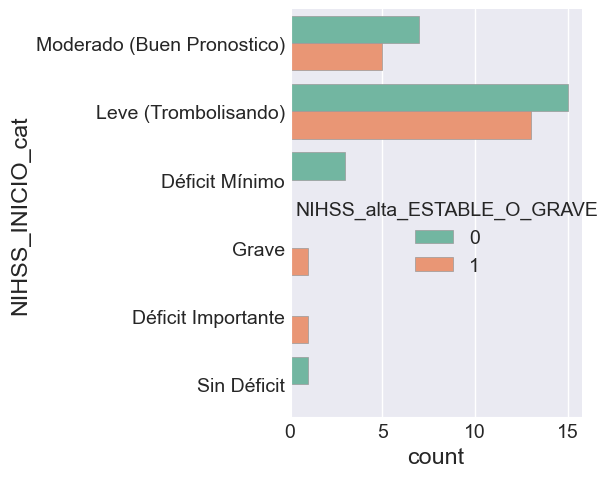

In [268]:
sns.catplot(y="NIHSS_INICIO_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [269]:
# Análisis GLASGOW AL INICO ACV

print(f'GLASGOW AL INICO ACV Variable min: {dataset["GLASGOW AL INICO ACV"].min()}')
print(f'GLASGOW AL INICO ACV Variable max: {dataset["GLASGOW AL INICO ACV"].max()}')
print(f'GLASGOW AL INICO ACV Variable: {dataset["GLASGOW AL INICO ACV"].nunique()}')

GLASGOW AL INICO ACV Variable min: 0.0
GLASGOW AL INICO ACV Variable max: 15.0
GLASGOW AL INICO ACV Variable: 7


In [270]:
dataset['GLASGOW_cat'] = pd.cut(dataset['GLASGOW AL INICO ACV'], bins=[-1, 8, 12, 15], labels=['Grave', 'Moderado', 'Leve'])

dataset['GLASGOW_cat'].unique()

['Moderado', 'Leve', 'Grave']
Categories (3, object): ['Grave' < 'Moderado' < 'Leve']

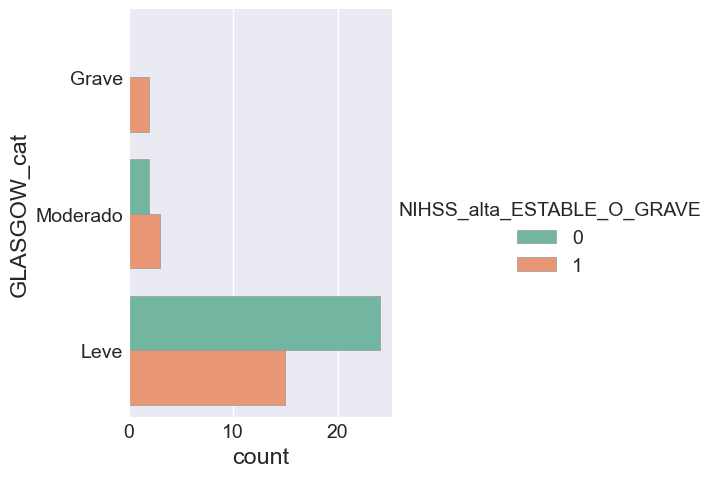

In [271]:
sns.catplot(y="GLASGOW_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

### Análisis de variables de médicas

In [272]:
# Análisis CONTEO G.B.

print(f'CONTEO G.B. Variable min: {dataset["CONTEO G.B."].min()}')
print(f'CONTEO G.B. Variable max: {dataset["CONTEO G.B."].max()}')
print(f'CONTEO G.B. Variable: {dataset["CONTEO G.B."].nunique()}')

CONTEO G.B. Variable min: 3.76
CONTEO G.B. Variable max: 41.9
CONTEO G.B. Variable: 38


In [273]:
dataset['CONTEO G.B._cat'] = pd.cut(dataset['CONTEO G.B.'], bins=[0, 4.5, 10,1000], labels=['Bajo', 'Normal', 'Alto'])

dataset['CONTEO G.B._cat'].unique()

['Alto', 'Normal', 'Bajo']
Categories (3, object): ['Bajo' < 'Normal' < 'Alto']

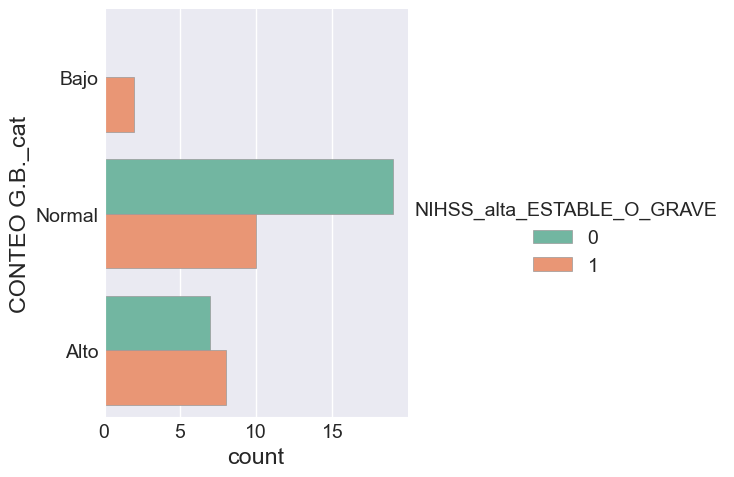

In [274]:
sns.catplot(y="CONTEO G.B._cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [275]:
# Análisis INR

print(f'INR Variable min: {dataset["INR"].min()}')
print(f'INR Variable max: {dataset["INR"].max()}')
print(f'INR Variable: {dataset["INR"].nunique()}')

INR Variable min: 0.89
INR Variable max: 3.08
INR Variable: 26


In [276]:
dataset['INR_cat'] = pd.cut(dataset['INR'], bins=[0.0, 2, 4,1000], labels=['Riesgo', 'Normal', 'No Anticoagula'])

dataset['INR_cat'].unique()

['Riesgo', 'Normal']
Categories (3, object): ['Riesgo' < 'Normal' < 'No Anticoagula']

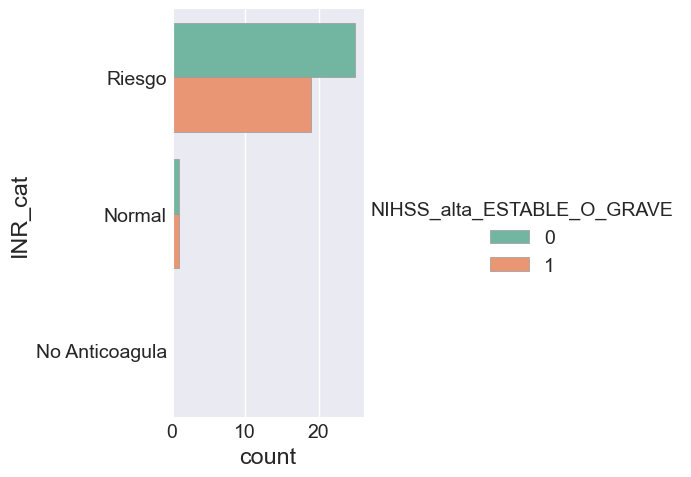

In [277]:
sns.catplot(y="INR_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [278]:
# Análisis TRIGLICERIDOS

print(f'TRIGLICERIDOS Variable min: {dataset["TRIGLICERIDOS"].min()}')
print(f'TRIGLICERIDOS Variable max: {dataset["TRIGLICERIDOS"].max()}')
print(f'TRIGLICERIDOS Variable: {dataset["TRIGLICERIDOS"].nunique()}')

TRIGLICERIDOS Variable min: 57.0
TRIGLICERIDOS Variable max: 232.0
TRIGLICERIDOS Variable: 31


In [279]:
dataset['TRIGLICERIDOS_cat'] = pd.cut(dataset['TRIGLICERIDOS'], bins=[0, 150, 200, 500, 10000], labels=['Normal', 'Límite alto', 'Alto', 'Muy Alto'])

dataset['TRIGLICERIDOS_cat'].unique()

['Normal', 'Límite alto', 'Alto']
Categories (4, object): ['Normal' < 'Límite alto' < 'Alto' < 'Muy Alto']

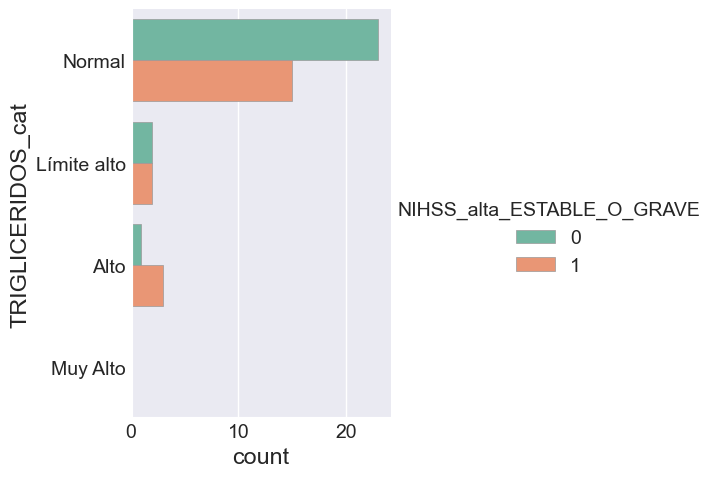

In [280]:
sns.catplot(y="TRIGLICERIDOS_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [281]:
# Análisis COL. TOTAL

print(f'COL. TOTAL Variable min: {dataset["COL. TOTAL"].min()}')
print(f'COL. TOTAL Variable max: {dataset["COL. TOTAL"].max()}')
print(f'COL. TOTAL Variable: {dataset["COL. TOTAL"].nunique()}')

COL. TOTAL Variable min: 85.0
COL. TOTAL Variable max: 342.0
COL. TOTAL Variable: 34


In [282]:
dataset['COL. TOTAL_cat'] = pd.cut(dataset['COL. TOTAL'], bins=[0, 150, 400, 1000, 100000], labels=['Normal', 'Límite alto', 'Alto', 'Muy Alto'])

dataset['COL. TOTAL_cat'].unique()

['Límite alto', 'Normal']
Categories (4, object): ['Normal' < 'Límite alto' < 'Alto' < 'Muy Alto']

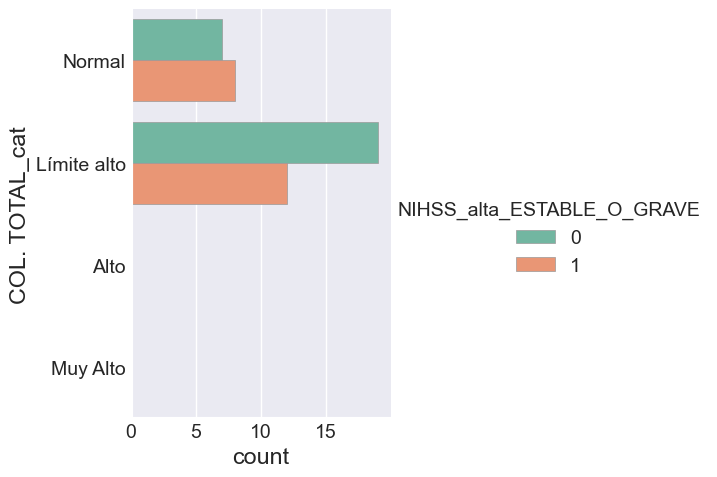

In [283]:
sns.catplot(y="COL. TOTAL_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [284]:
# Análisis EDAD

print(f'GLUCOSA Variable min: {dataset["GLUCOSA"].min()}')
print(f'GLUCOSA Variable max: {dataset["GLUCOSA"].max()}')
print(f'GLUCOSA Variable: {dataset["GLUCOSA"].nunique()}')

GLUCOSA Variable min: 82.61
GLUCOSA Variable max: 359.42
GLUCOSA Variable: 39


In [285]:
dataset['GLUCOSA_cat'] = pd.cut(dataset['GLUCOSA'], bins=[0, 90, 160, 230, 3000], labels=['Bajo', 'Normal', 'Alto', 'Muy Alto'])

dataset['GLUCOSA_cat'].unique()

['Normal', 'Muy Alto', 'Alto', 'Bajo']
Categories (4, object): ['Bajo' < 'Normal' < 'Alto' < 'Muy Alto']

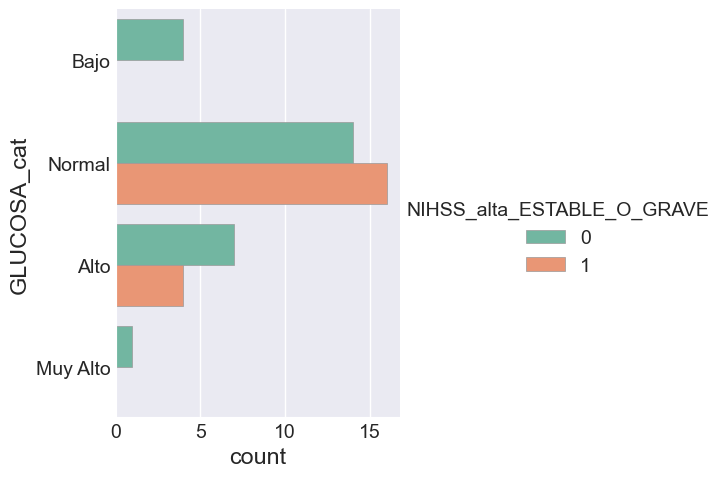

In [286]:
sns.catplot(y="GLUCOSA_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [287]:
# Análisis EDAD

print(f'EDAD Variable min: {dataset["EDAD"].min()}')
print(f'EDAD Variable max: {dataset["EDAD"].max()}')
print(f'EDAD Variable: {dataset["EDAD"].nunique()}')

EDAD Variable min: 38.0
EDAD Variable max: 90.0
EDAD Variable: 28


In [288]:
dataset['EDAD_cat'] = pd.cut(dataset['EDAD'], bins=[0, 13, 18, 45, 60, 100], labels=['Niño', 'Adolecente', 'Adulto Joven', 'Adulto', 'Anciano'])

dataset['EDAD_cat'].unique()

['Adulto', 'Anciano', 'Adulto Joven']
Categories (5, object): ['Niño' < 'Adolecente' < 'Adulto Joven' < 'Adulto' < 'Anciano']

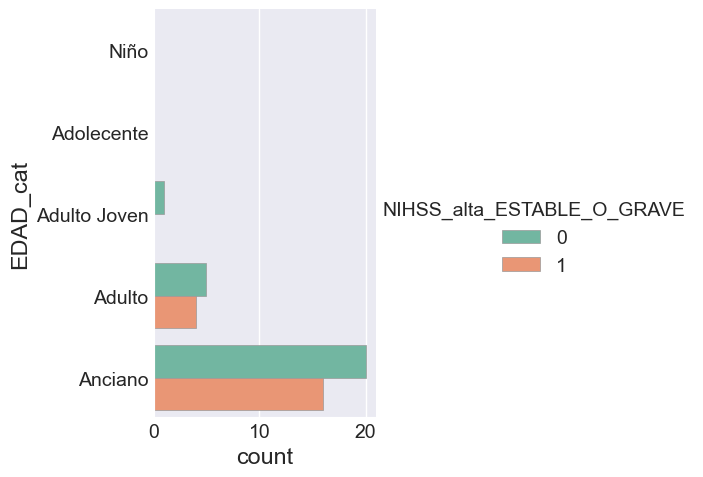

In [289]:
sns.catplot(y="EDAD_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [290]:
# Análisis DIABETES

print(f'DIABETES Variable min: {dataset["DIABETES"].min()}')
print(f'DIABETES Variable max: {dataset["DIABETES"].max()}')
print(f'DIABETES Variable: {dataset["DIABETES"].nunique()}')

DIABETES Variable min: DESCONOCIDO
DIABETES Variable max: si
DIABETES Variable: 3


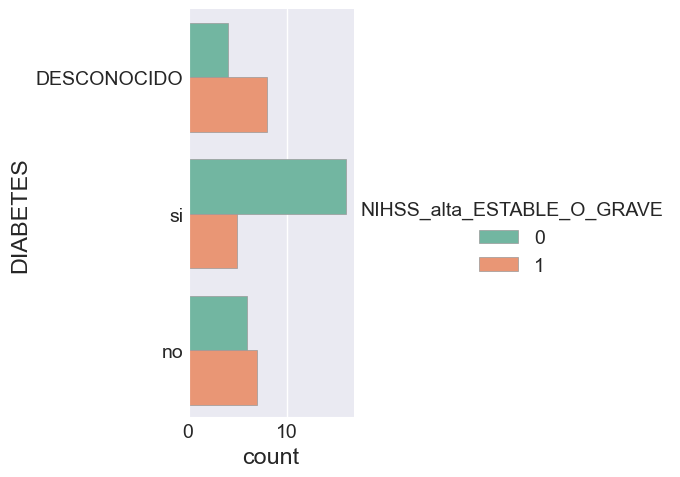

In [291]:
sns.catplot(y="DIABETES", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [292]:
# Análisis DIABETES

print(f'HTA Variable min: {dataset["HTA"].min()}')
print(f'HTA Variable max: {dataset["HTA"].max()}')
print(f'HTA Variable: {dataset["HTA"].nunique()}')

HTA Variable min: DESCONOCIDO
HTA Variable max: si
HTA Variable: 3


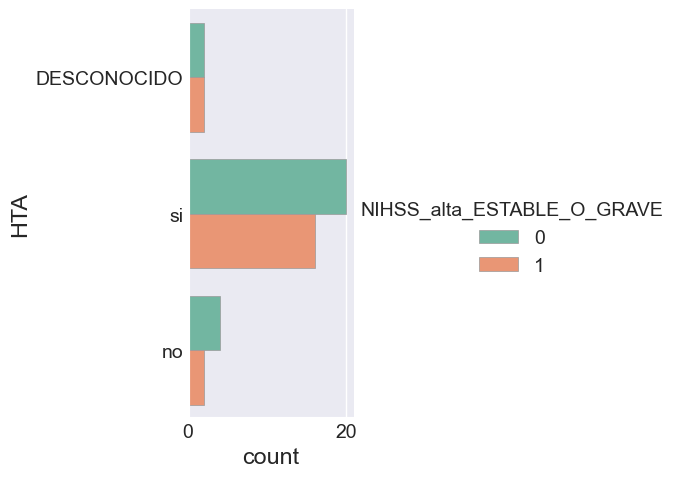

In [293]:
sns.catplot(y="HTA", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".6",
            data=dataset)

In [294]:
dataset.head()

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE,NIHSS_INICIO_cat,GLASGOW_cat,CONTEO G.B._cat,INR_cat,TRIGLICERIDOS_cat,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat
0,DESCONOCIDO,DESCONOCIDO,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0,Grave,1,Moderado (Buen Pronostico),Moderado,Alto,Riesgo,Normal,Límite alto,Normal,Adulto
1,si,si,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0,Sin Déficit,0,Moderado (Buen Pronostico),Leve,Normal,Riesgo,Normal,Límite alto,Normal,Adulto
2,si,si,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0,Leve (Trombolisando),0,Leve (Trombolisando),Leve,Normal,Riesgo,Normal,Límite alto,Muy Alto,Anciano
3,si,si,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0,Sin Déficit,0,Déficit Mínimo,Leve,Normal,Riesgo,Normal,Límite alto,Alto,Anciano
4,si,si,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0,Leve (Trombolisando),0,Leve (Trombolisando),Leve,Alto,Riesgo,Normal,Límite alto,Alto,Anciano


## Transformación de los datos

## Binary Encoding (Codificación binaria)

Lo que hace este proceso es la transformación de variables de una columna a binario si es posible

In [295]:
binary_cols = [col for col in dataset.columns if dataset[col].dtype not in [int, float]
               and dataset[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols

['INR_cat', 'COL. TOTAL_cat']

In [296]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

for col in binary_cols:
    label_encoder(dataset, col)
    
dataset.head()

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE,NIHSS_INICIO_cat,GLASGOW_cat,CONTEO G.B._cat,INR_cat,TRIGLICERIDOS_cat,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat
0,DESCONOCIDO,DESCONOCIDO,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0,Grave,1,Moderado (Buen Pronostico),Moderado,Alto,1,Normal,0,Normal,Adulto
1,si,si,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0,Sin Déficit,0,Moderado (Buen Pronostico),Leve,Normal,1,Normal,0,Normal,Adulto
2,si,si,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0,Leve (Trombolisando),0,Leve (Trombolisando),Leve,Normal,1,Normal,0,Muy Alto,Anciano
3,si,si,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0,Sin Déficit,0,Déficit Mínimo,Leve,Normal,1,Normal,0,Alto,Anciano
4,si,si,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0,Leve (Trombolisando),0,Leve (Trombolisando),Leve,Alto,1,Normal,0,Alto,Anciano


## Label Encoding (Codificación de etiquetas)

In [297]:
labelencoder = LabelEncoder()

In [298]:
dataset["NIHSS_alta_cat"] = labelencoder.fit_transform(dataset["NIHSS_alta_cat"])
dataset["GLASGOW_cat"] = labelencoder.fit_transform(dataset["GLASGOW_cat"])
dataset["CONTEO G.B._cat"] = labelencoder.fit_transform(dataset["CONTEO G.B._cat"])
dataset["TRIGLICERIDOS_cat"] = labelencoder.fit_transform(dataset["TRIGLICERIDOS_cat"])
dataset["GLUCOSA_cat"] = labelencoder.fit_transform(dataset["GLUCOSA_cat"])
dataset["EDAD_cat"] = labelencoder.fit_transform(dataset["EDAD_cat"])
dataset["HTA"] = labelencoder.fit_transform(dataset["HTA"])
dataset["DIABETES"] = labelencoder.fit_transform(dataset["DIABETES"])

dataset.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE,NIHSS_INICIO_cat,GLASGOW_cat,CONTEO G.B._cat,INR_cat,TRIGLICERIDOS_cat,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat
0,0,0,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0,2,1,Moderado (Buen Pronostico),2,0,1,2,0,3,0
1,2,2,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0,5,0,Moderado (Buen Pronostico),1,2,1,2,0,3,0
2,2,2,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0,3,0,Leve (Trombolisando),1,2,1,2,0,2,2
3,2,2,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0,5,0,Déficit Mínimo,1,2,1,2,0,0,2
4,2,2,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0,3,0,Leve (Trombolisando),1,0,1,2,0,0,2


## One-Hot Encoding:

In [299]:
# One Hot Encoding
dataset = pd.get_dummies(dataset)


# Como son muchas columnas, muestro todas
pd.options.display.max_columns = 0

dataset.head(5)

# Lista de características para uso posterior
features = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)
feature_list = list(features.columns)

# Modelo de Machine Learning

<h1 align='center'>  Bosque Aleatorio </h1> 
<h2 align='center'>  Clasificación </h2> 

# 5-. Entrenar el modelo en los datos de entrenamiento

In [300]:
# variables objetivo e independientes:
from sklearn.model_selection import train_test_split

# X son nuestras variables independientes
X = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)

# y es nuestra variable dependiente
y = dataset['NIHSS_alta_ESTABLE_O_GRAVE']

# Uso de Skicit-learn para dividir datos en conjuntos de entrenamiento y prueba 
# División 75% de datos para entrenamiento, 25% de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

## Creamos el modelo y entrenamos

In [301]:
from sklearn.ensemble import RandomForestClassifier

# Creamos el modelo de Bosque Aleatorio (y configuramos el número máximo de nodos-hoja)
rfc = RandomForestClassifier(max_depth = 5,criterion = 'gini', random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

### Estructura del árbol creado

In [302]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 2


In [303]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'randomForestClassification.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('randomForestClassification.dot')

# Write graph to a png file
graph.write_png('randomForestClassification.png'); 

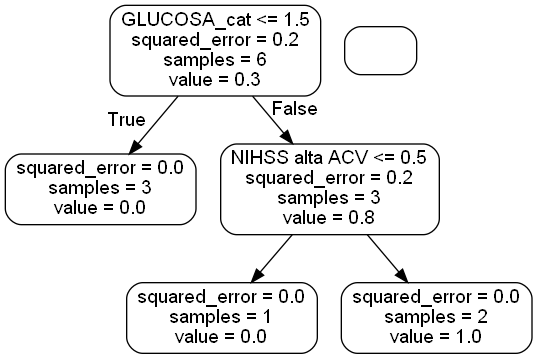

# 6-. Predicciones sobre los datos de prueba
Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [304]:
# Predicción Entrenamiento 
prediccionEntreno = rfc.predict(X_train)

# Predicción Tests
prediccionTests = rfc.predict(X_test)

# Fase de Entrenamiento

In [305]:
from sklearn import metrics

print("Entrenamiento - Presición :", metrics.accuracy_score(y_train, prediccionEntreno))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_train, prediccionEntreno))

Entrenamiento - Presición : 1.0
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



### Matriz de Confusión

En el campo de la inteligencia artificial y en especial en el problema de la clasificación estadística, una matriz de confusión es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado.

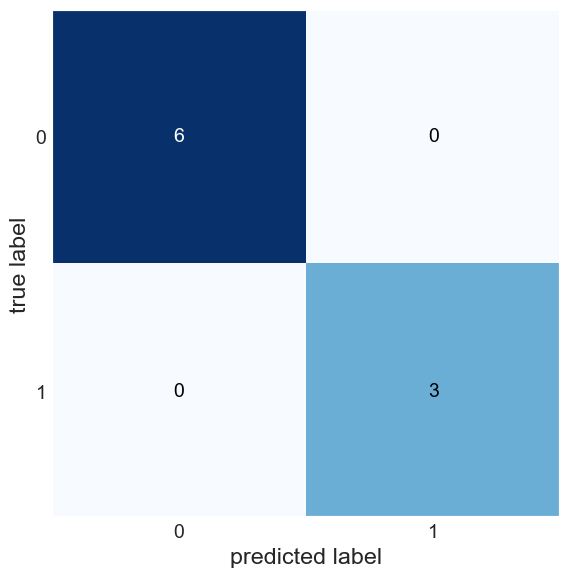

In [306]:
from matplotlib import pyplot as plot
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

matriz = confusion_matrix(y_train, prediccionEntreno)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plot.tight_layout()

# 7-. Comparar las predicciones con los objetivos conocidos del conjunto de pruebas y calcule las métricas de rendimiento
Una vez entrenado el modelo, se pueden predecir nuevas observaciones.

# Fase de validación (Usando datos de Test)

In [307]:
print("Tests - Presición :", metrics.accuracy_score(y_test, prediccionTests))
print("Tests - Reporte de clasificación:\n", metrics.classification_report(y_test, prediccionTests))

Tests - Presición : 0.6216216216216216
Tests - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.67      0.35      0.46        17

    accuracy                           0.62        37
   macro avg       0.64      0.60      0.58        37
weighted avg       0.63      0.62      0.59        37



### Matriz de Confusión

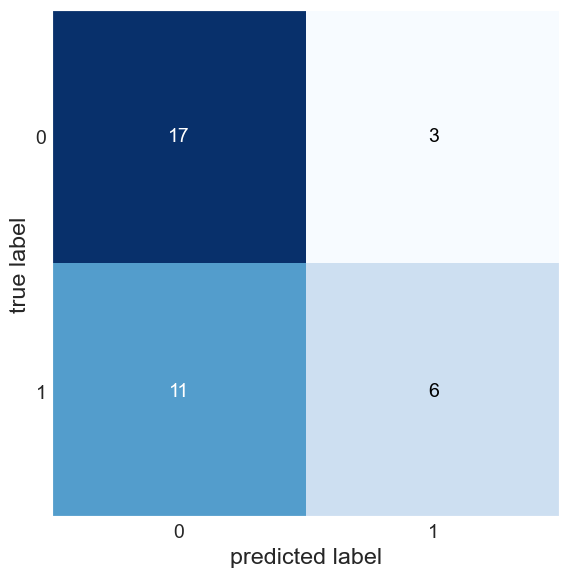

In [308]:
matriz = confusion_matrix(y_test, prediccionTests)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plt.tight_layout()

# 8-. Importancia de los predictores
Por experiencia previa y los gráficos producidos al principio, sabemos que algunas características no son útiles para nuestro problema de predicción. Para reducir la cantidad de funciones, lo que reducirá el tiempo de ejecución, con suerte sin reducir significativamente el rendimiento, podemos examinar la importancia de las funciones del Arbol de Decisión.

In [309]:
# Predicciones probabilísticas
# ==============================================================================
# Con .predict_proba() se obtiene, para cada observación, la probabilidad predicha
# de pertenecer a cada una de las dos clases.
predicciones = rfc.predict_proba(X = X_test)
predicciones = pd.DataFrame(predicciones, columns = rfc.classes_)
predicciones.head(3)

,0,1
0,0.64,0.36
1,0.74,0.26
2,0.76,0.24


In [310]:
# Predicciones con clasificación final
# ==============================================================================
# Con .predict() se obtiene, para cada observación, la clasificación predicha por
# el modelo. Esta clasificación se corresponde con la clase con mayor probabilidad.
predicciones = rfc.predict(X = X_test)
predicciones

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [311]:
importancia_predictores = pd.DataFrame(
                            {'Predictor': dataset.drop(columns = "NIHSS_alta_ESTABLE_O_GRAVE").columns,
                             'importancia': rfc.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,importancia
5,TRIGLICERIDOS,0.149579
2,EDAD,0.098917
9,NIHSS INICO ACV,0.087893
4,COL. TOTAL,0.079422
3,GLUCOSA,0.076047
17,GLUCOSA_cat,0.063920
16,COL. TOTAL_cat,0.060227
10,NIHSS alta ACV,0.056171
6,INR,0.054726
7,CONTEO G.B.,0.052931


In [312]:
# Lista de características para uso posterior
features = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TRIGLICERIDOS        Importance: 0.15
Variable: EDAD                 Importance: 0.1
Variable: NIHSS INICO ACV      Importance: 0.09
Variable: GLUCOSA              Importance: 0.08
Variable: COL. TOTAL           Importance: 0.08
Variable: NIHSS alta ACV       Importance: 0.06
Variable: COL. TOTAL_cat       Importance: 0.06
Variable: GLUCOSA_cat          Importance: 0.06
Variable: DIABETES             Importance: 0.05
Variable: INR                  Importance: 0.05
Variable: CONTEO G.B.          Importance: 0.05
Variable: CONTEO G.B._cat      Importance: 0.05
Variable: GLASGOW AL INICO ACV Importance: 0.04
Variable: NIHSS_alta_cat       Importance: 0.04
Variable: NIHSS_INICIO_cat_Leve (Trombolisando) Importance: 0.02
Variable: HTA                  Importance: 0.01
Variable: NIHSS_INICIO_cat_Déficit Mínimo Importance: 0.01
Variable: GLASGOW_cat          Importance: 0.0
Variable: INR_cat              Importance: 0.0
Variable: TRIGLICERIDOS_cat    Importance: 0.0
Variable: EDAD_c

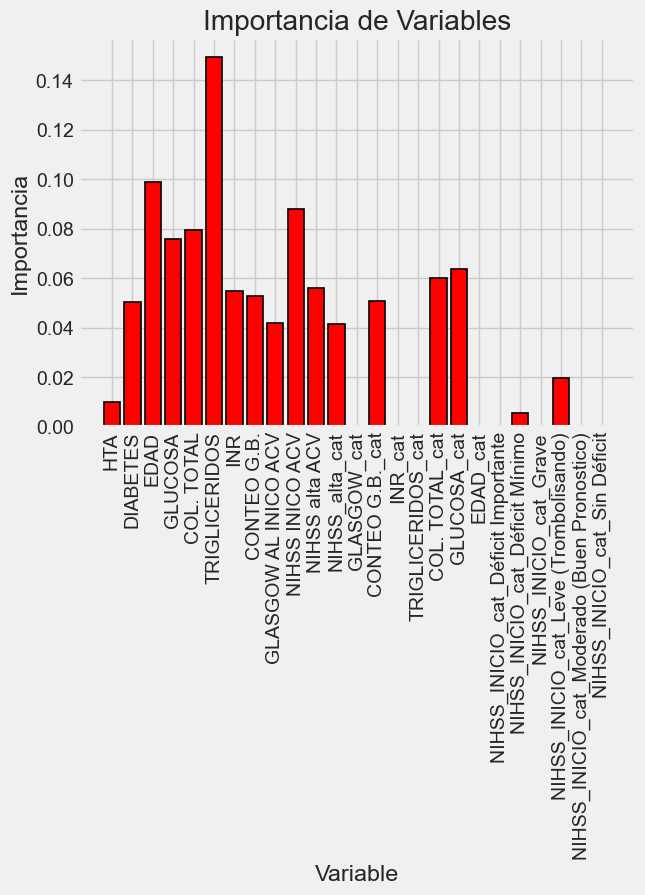

In [313]:
# Reset style 
plt.style.use('fivethirtyeight')

# lista de x ubicaciones para trazar
x_values = list(range(len(importances)))

# Gráfico de barras
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Marque las etiquetas para el eje x
plt.xticks(x_values, feature_list, rotation='vertical')

# Etiquetas de eje y título
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de Variables');

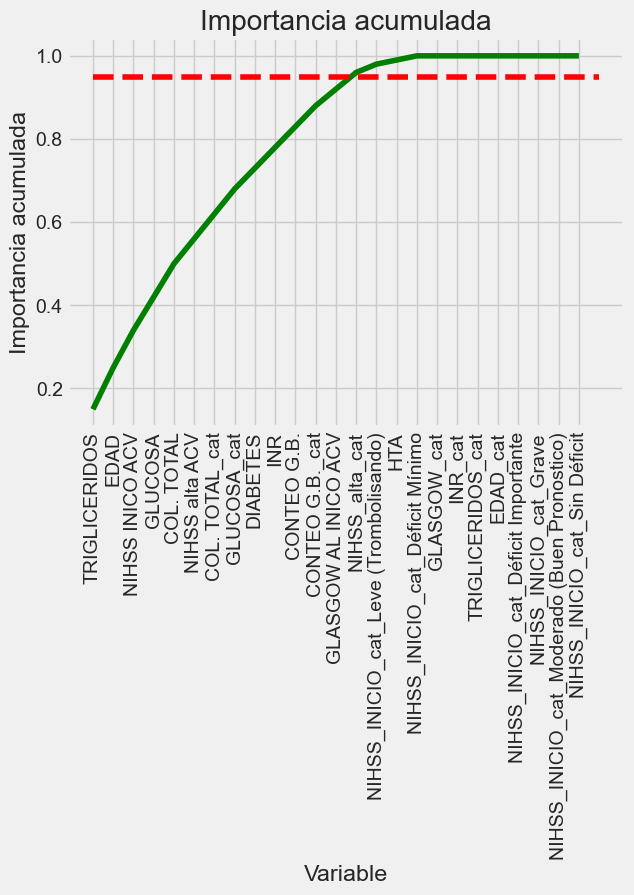

In [314]:
# Lista de funciones ordenadas de mayor a menor importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Importancias acumulativas
cumulative_importances = np.cumsum(sorted_importances)

# Haz un gráfico de líneas
plt.plot(x_values, cumulative_importances, 'g-')

# Dibujar línea al 95% de importancia retenida
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Formato x ticks y etiquetas
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Etiquetas de eje y título
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancia acumulada');

## Limite el número de características

Ahora reduciremos la cantidad de funciones en uso por el modelo a solo aquellas requeridas para representar el 95% de la importancia. Se debe usar el mismo número de características en los conjuntos de entrenamiento y prueba.

In [315]:
# Encuentre el número de características para una importancia acumulada del 95%
# Agregue 1 porque Python está indexado a cero
print('Número de columna para el 95 % de importancia:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Número de columna para el 95 % de importancia: 14


# Modelo de Machine Learning

<h1 align='center'>  Bosque Aleatorio </h1> 
<h2 align='center'>  Regresión </h2> 

# 5-. Entrenar el modelo en los datos de entrenamiento

In [316]:
# variables objetivo e independientes:
from sklearn.model_selection import train_test_split

# X son nuestras variables independientes
X = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)

# y es nuestra variable dependiente
y = dataset['NIHSS_alta_ESTABLE_O_GRAVE']

# Uso de Skicit-learn para dividir datos en conjuntos de entrenamiento y prueba 
# División 75% de datos para entrenamiento, 25% de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

## Creamos el modelo y entrenamos

In [317]:
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo de Bosque Aleatorio (y configuramos el número máximo de nodos-hoja)
rfr = RandomForestRegressor(max_depth = 5, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

### Estructura del árbol creado

In [318]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 2


In [319]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'randomForestRegression.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('randomForestRegression.dot')

# Write graph to a png file
graph.write_png('randomForestRegression.png'); 

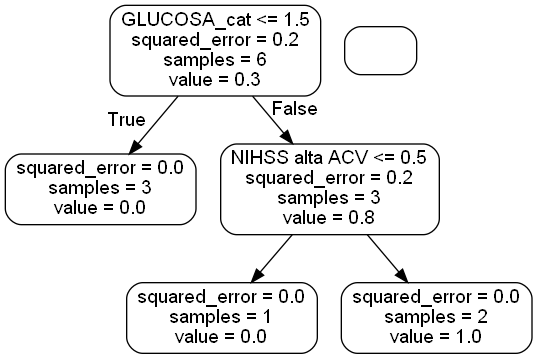

# 6-. Predicciones sobre los datos de prueba
Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [320]:
# Predicción Entrenamiento 
prediccionEntreno = rfr.predict(X_train)

# Predicción Tests
prediccionTests = rfr.predict(X_test)

# Fase de Entrenamiento

In [321]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

# Función de puntuación de regresión de varianza explicada.
print("Entrenamiento - Varianza :", explained_variance_score(y_train, prediccionEntreno))
print("Entrenamiento - Error Absoluto :", mean_absolute_error(y_train, prediccionEntreno))

Entrenamiento - Varianza : 0.8060999999999999
Entrenamiento - Error Absoluto : 0.1922222222222222


In [322]:
from sklearn import metrics

# Aqui nos arroja resultados inválidos, ya que es una técnica de regresión y nos da resultados ya que en las de regresión son números de predicción
print("Entrenamiento - Presición :", metrics.accuracy_score(y_train, prediccionEntreno.round(), normalize=False))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_train, prediccionEntreno.round()))

Entrenamiento - Presición : 9
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



# 7-. Comparar las predicciones con los objetivos conocidos del conjunto de pruebas y calcule las métricas de rendimiento
Una vez entrenado el modelo, se pueden predecir nuevas observaciones.

# Fase de validación (Usando datos de Test)

In [323]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

# Función de puntuación de regresión de varianza explicada.
print("Entrenamiento - Varianza :", explained_variance_score(y_test, prediccionTests))
print("Entrenamiento - Error Absoluto :", mean_absolute_error(y_test, prediccionTests))

Entrenamiento - Varianza : 0.2733547058823532
Entrenamiento - Error Absoluto : 0.40378378378378377


In [324]:
# Aqui nos arroja resultados inválidos, ya que es una técnica de regresión y nos da resultados ya que en las de regresión son números de predicción
print("Entrenamiento - Presición :", metrics.accuracy_score(y_test, prediccionTests.round(), normalize=False))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_test, prediccionTests.round()))

Entrenamiento - Presición : 27
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.68      0.95      0.79        20
           1       0.89      0.47      0.62        17

    accuracy                           0.73        37
   macro avg       0.78      0.71      0.70        37
weighted avg       0.78      0.73      0.71        37



# 8-. Importancia de los predictores
Por experiencia previa y los gráficos producidos al principio, sabemos que algunas características no son útiles para nuestro problema de predicción. Para reducir la cantidad de funciones, lo que reducirá el tiempo de ejecución, con suerte sin reducir significativamente el rendimiento, podemos examinar la importancia de las funciones del Arbol de Decisión.

## Interpretación el modelo, reporte los resultados visual y numéricamente

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el índice Gini, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [325]:
# Predicciones con clasificación final
# ==============================================================================
# Con .predict() se obtiene, para cada observación, la clasificación predicha por
# el modelo. Esta clasificación se corresponde con la clase con mayor probabilidad.
predicciones = rfr.predict(X = X_test)
predicciones

array([0.31, 0.26, 0.24, 0.17, 0.49, 0.4 , 0.52, 0.4 , 0.55, 0.71, 0.3 ,
       0.22, 0.21, 0.35, 0.28, 0.25, 0.42, 0.71, 0.69, 0.5 , 0.26, 0.43,
       0.32, 0.39, 0.35, 0.55, 0.6 , 0.58, 0.42, 0.49, 0.27, 0.46, 0.24,
       0.39, 0.5 , 0.4 , 0.61])

In [326]:
importancia_predictores = pd.DataFrame(
                            {'Predictor': dataset.drop(columns = "NIHSS_alta_ESTABLE_O_GRAVE").columns,
                             'importancia': rfr.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,importancia
5,TRIGLICERIDOS,0.179683
2,EDAD,0.099026
11,NIHSS_alta_cat,0.098362
9,NIHSS INICO ACV,0.096681
17,GLUCOSA_cat,0.085693
3,GLUCOSA,0.072092
1,DIABETES,0.068903
4,COL. TOTAL,0.055873
6,INR,0.050415
7,CONTEO G.B.,0.044192


In [327]:
# Lista de características para uso posterior
features = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rfr.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TRIGLICERIDOS        Importance: 0.18
Variable: EDAD                 Importance: 0.1
Variable: NIHSS INICO ACV      Importance: 0.1
Variable: NIHSS_alta_cat       Importance: 0.1
Variable: GLUCOSA_cat          Importance: 0.09
Variable: DIABETES             Importance: 0.07
Variable: GLUCOSA              Importance: 0.07
Variable: COL. TOTAL           Importance: 0.06
Variable: INR                  Importance: 0.05
Variable: CONTEO G.B.          Importance: 0.04
Variable: COL. TOTAL_cat       Importance: 0.04
Variable: GLASGOW AL INICO ACV Importance: 0.03
Variable: NIHSS alta ACV       Importance: 0.03
Variable: CONTEO G.B._cat      Importance: 0.03
Variable: HTA                  Importance: 0.01
Variable: GLASGOW_cat          Importance: 0.0
Variable: INR_cat              Importance: 0.0
Variable: TRIGLICERIDOS_cat    Importance: 0.0
Variable: EDAD_cat             Importance: 0.0
Variable: NIHSS_INICIO_cat_Déficit Importante Importance: 0.0
Variable: NIHSS_INICIO_cat_Défici

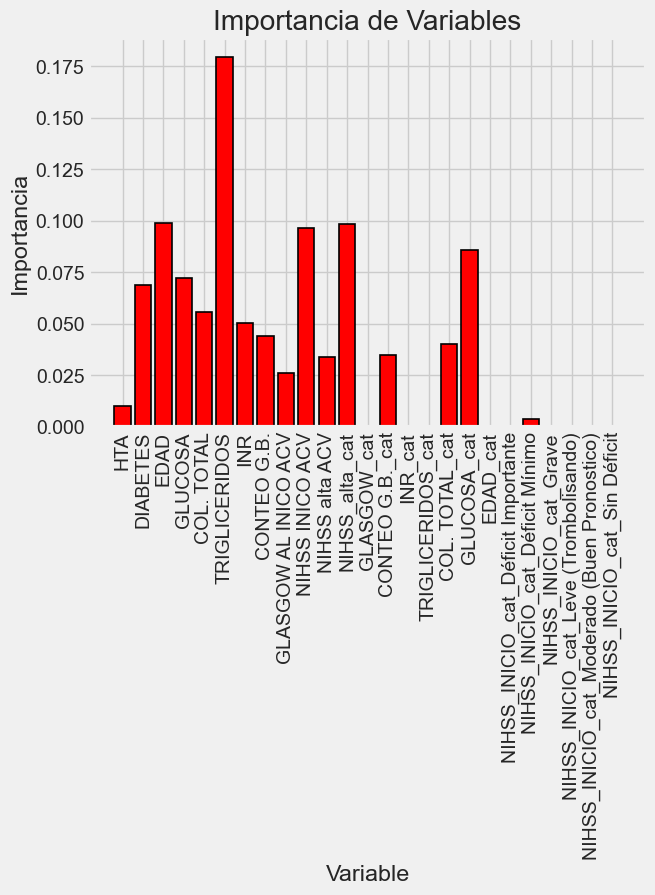

In [328]:
# Reset style 
plt.style.use('fivethirtyeight')

# lista de x ubicaciones para trazar
x_values = list(range(len(importances)))

# Gráfico de barras
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Marque las etiquetas para el eje x
plt.xticks(x_values, feature_list, rotation='vertical')

# Etiquetas de eje y título
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de Variables');

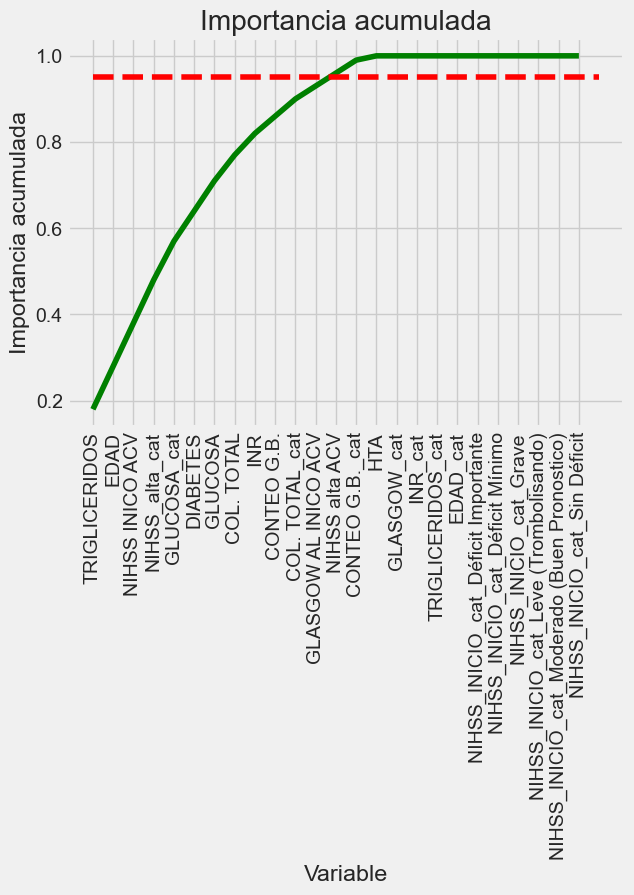

In [329]:
# Lista de funciones ordenadas de mayor a menor importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Importancias acumulativas
cumulative_importances = np.cumsum(sorted_importances)

# Haz un gráfico de líneas
plt.plot(x_values, cumulative_importances, 'g-')

# Dibujar línea al 95% de importancia retenida
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Formato x ticks y etiquetas
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Etiquetas de eje y título
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancia acumulada');

### Limite el número de características
Ahora reduciremos la cantidad de funciones en uso por el modelo a solo aquellas requeridas para representar el 95% de la importancia. Se debe usar el mismo número de características en los conjuntos de entrenamiento y prueba.

In [330]:
# Encuentre el número de características para una importancia acumulada del 95%
# Agregue 1 porque Python está indexado a cero
print('Número de columna para el 95 % de importancia:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Número de columna para el 95 % de importancia: 13


# Extrapolación con modelos de árboles

Una límitación importante de los árboles de regresión es que no extrapolan fuera del rango de entrenamiento. Cuando se aplica el modelo a una nueva observación, cuyo valor o valores de los predictores son superiores o inferiores a los observados en el entrenamiento, la predicción siempre es la media del nodo más cercano, independientemente de cuanto se aleje el valor. Vease el siguiente ejemplo en el que se entrenan dos modelos, un modelo lineal y un arbol de regresión, y luego se predicen valores de  X  fuera del rango de entrenamiento.

In [331]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

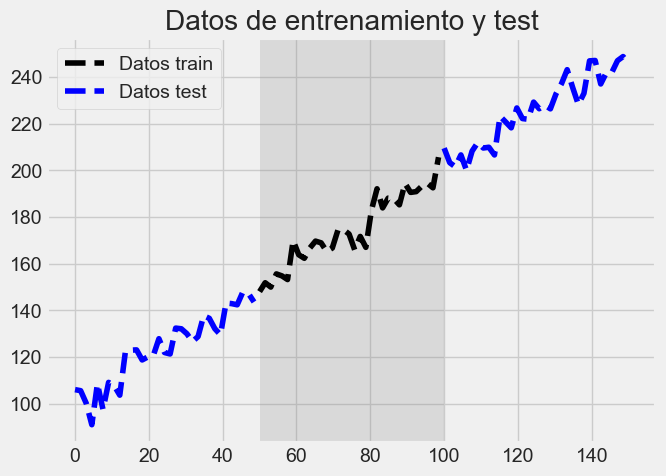

In [332]:
# Datos simulados
# ------------------------------------------------------------------------------
X = np.linspace(0, 150, 100)
y = (X + 100) + np.random.normal(loc=0.0, scale=5.0, size=X.shape)
X_train = X[(X>=50) & (X<100)]
y_train = y[(X>=50) & (X<100)]
X_test_inf = X[X < 50]
y_test_inf = y[X < 50]
X_test_sup = X[X >= 100]
y_test_sup = y[X >= 100]

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.set_title("Datos de entrenamiento y test")
plt.legend();

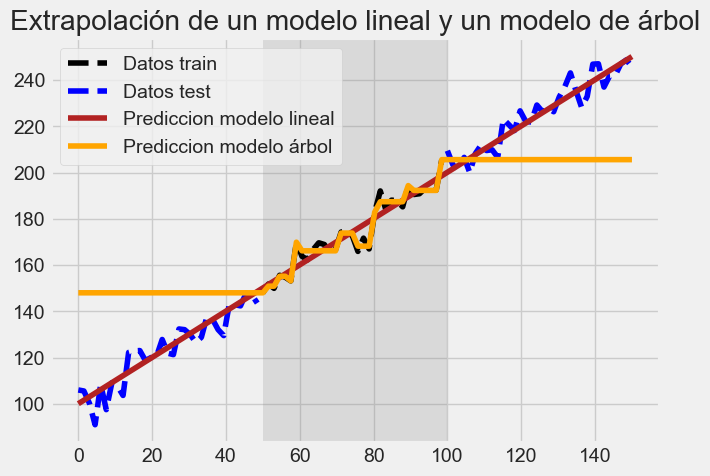

In [333]:
# Modelo lineal
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train.reshape(-1, 1), y_train)

# Modelo árbol
modelo_tree = DecisionTreeRegressor(max_depth=4)
modelo_tree.fit(X_train.reshape(-1, 1), y_train)

# Predicciones
prediccion_lineal = modelo_lineal.predict(X.reshape(-1, 1))
prediccion_tree   = modelo_tree.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.plot(X, prediccion_lineal, c='firebrick',
        label = "Prediccion modelo lineal")
ax.plot(X, prediccion_tree, c='orange',
        label = "Prediccion modelo árbol")
ax.set_title("Extrapolación de un modelo lineal y un modelo de árbol")
plt.legend();